In [4]:
#combine both 
#nmad+oun
#time is fixed at t=1, l,k and m are changing 
import matplotlib.pyplot as plt
import numpy as np
import cmath
import math
import scipy.integrate as scint

def g2(l,k,t): #nmad gamma2
    d=cmath.sqrt(l**2-2*k*l)
    g2=(4*k*(l/d)*cmath.sinh(0.5*d*t))/(cmath.cosh(0.5*d*t)+(l/d)*cmath.sinh(0.5*d*t))
    return g2.real

def g3(m,c,t,marker): #oun gamma3
    if marker==1: #non markovian
        g3=0.5*c*(1-np.exp(-m*t))
    if marker==0:#Markovian
        g3=0.5*c
    return g3.real    

def tevolve(l,k,m,c,t,rho,marker): #complex stuff here 
    d=cmath.sqrt(l**2-2*k*l)
    rhot=np.zeros((2,2))
    xt=np.exp(-l*t)*(cmath.cosh(0.5*d*t)+(l/d)*cmath.sinh(0.5*d*t))**2
    p1t=xt*rho[1,1]+1-xt
    if marker==1: #non markovian
        oun=0.5*c*(t+(np.exp(-m*t)-1)/m)
    if marker==0:
        oun=0.5*c*t
    coh=rho[0,1]*cmath.sqrt(xt)*np.exp(-oun)
    rhot[0,0]=1-p1t.real
    rhot[1,1]=p1t.real
    rhot[0,1]=coh.real
    rhot[1,0]=coh.real
    return rhot

def lind(l,k,m,c,t,rhot):
    sz=np.array([[1,0],[0,-1]])
    sp=np.array([[0,1],[0,0]])
    sm=np.array([[0,0],[1,0]])
    ld=np.zeros((2,2))
    ld=0.5*g2(l,k,t)*(sm@rhot@sp-0.5*(sp@sm@rhot+rhot@sp@sm))+ 0.5*g3(m,c,t,marker)*(sz@rhot@sz-rhot)
    return ld

def maxvalgen(l,k,m,c,t,rho,marker): #generates the required max value
    rhot=tevolve(l,k,m,c,t,rho,marker)
    norm=lind(l,k,m,c,t,rhot).T@lind(l,k,m,c,t,rhot)
    val=np.linalg.eig(norm)[0]
    fx=np.sqrt(max(abs(val))) #converts into float from complex
    return fx

def bures(l,k,m,c,time,rho,marker): #the Bures angle 
    z1=0
    garb=np.zeros((2,2))
    garb=tevolve(l,k,m,c,time,rho,marker)@rho
    z1=math.acos(abs(np.sqrt(garb.trace()))+2*np.sqrt(np.linalg.det(rho)*np.linalg.det(tevolve(l,k,m,c,time,rho,marker))))
    b=np.sin(z1)**2
    return b

k=np.arange(0.1,50,0.1)
l=0.1*k
#l=10*k
m=l
c=10
cases=2 #will have a marker to tell if its markovian or non markovian

rho=np.array([[0.5,0.5],[0.5,0.5]])  #time=np.arange(0,300,dt) 
time=1 #will give upper limits
n=200;#no. of points in the smaller integrations

a=0 #lower limit
b=time #upper limit
fint=np.zeros((cases,len(k)))
bur=np.zeros((cases,len(k)))
qsl=np.zeros((cases,len(k)))
revqsl=np.zeros((cases,len(k)))
for j in range(cases):
    for i in range(len(k)):
        if j==cases-1:
            marker=1
        else:
            marker=0
        f=lambda x:maxvalgen(l[i],k[i],m[i],c,x,rho,marker)
        fint[j,i]=scint.quad(f,a,b)[0]
        bur[j,i]=bures(l[i],k[i],m[i],c,time,rho,marker)
    qsl[j,:]=np.divide(bur[j,:],fint[j,:])
    revqsl[j,:]=np.divide(fint[j,:],bur[j,:])

rhot=np.zeros((2,2))
rho=np.array([[0.5,0.5],[0.5,0.5]]) 
garb=np.zeros((2,2))
Cpar=np.zeros((cases,len(k)))
mix=np.zeros((cases,len(k)))
bound=np.zeros((cases,len(k)))
for j in range(cases):
    for i in range(len(k)):
        if j==cases-1:
            marker=1
        else:
            marker=0
        rhot=tevolve(l[i],k[i],m[i],c,time,rho,marker)
        Cpar[j,i]=abs(rhot[0,1])+abs(rhot[1,0])
        garb=rhot@rhot
        mix[j,i]=2*(1-garb.trace())
        bound[j,i]=Cpar[j,i]**2+mix[j,i]
        i=i+1
    i=0

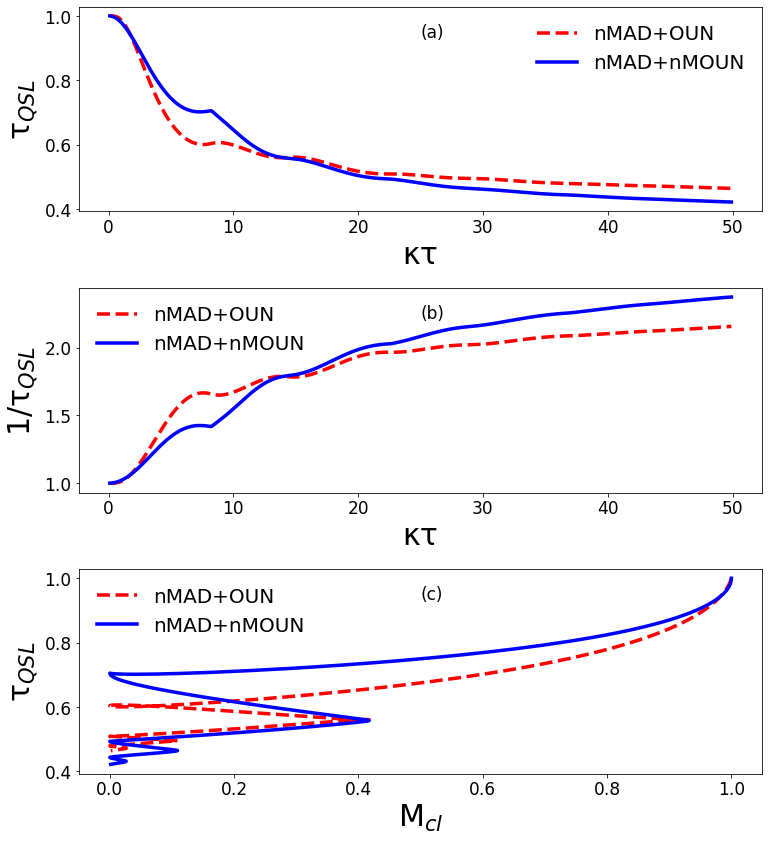

In [3]:
import matplotlib.gridspec as gridspec
fig = plt.figure(tight_layout=True,figsize=(11,12))
plt.rcParams.update({'font.size': 17})
gs = gridspec.GridSpec(3, 3)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(k,qsl[0,:],'r--',linewidth=3.5, label='nMAD+OUN')
ax1.plot(k,qsl[1,:],'b', linewidth=3.5, label='nMAD+nMOUN')
ax1.set_xlabel('\u03BA\u03C4',fontsize=30)
ax1.set_ylabel('\u03C4$_{QSL}$',fontsize=30)
ax1.text(0.5, 0.85, '(a)',transform=ax1.transAxes)
ax1.legend(frameon=False, fontsize=20)

ax2 = fig.add_subplot(gs[1, :])
ax2.plot(k,revqsl[0,:],'r--',linewidth=3.5, label='nMAD+OUN')
ax2.plot(k,revqsl[1,:],'b',linewidth=3.5, label='nMAD+nMOUN')
ax2.legend(frameon=False, fontsize=20)
ax2.text(0.5, 0.85, '(b)',transform=ax2.transAxes)
ax2.set_xlabel('\u03BA\u03C4',fontsize=30)
ax2.set_ylabel('1/\u03C4$_{QSL}$',fontsize=30)

ax3 = fig.add_subplot(gs[2, :])
ax3.plot(bound[0,:],qsl[0,:],'r--',linewidth=3.5,label='nMAD+OUN')
ax3.plot(bound[1,:],qsl[1,:],'b',linewidth=3.5,label='nMAD+nMOUN')
ax3.text(0.5, 0.85, '(c)',transform=ax3.transAxes)
ax3.legend(frameon=False, fontsize=20)
ax3.set_xlabel('M$_{cl}$',fontsize=30)
ax3.set_ylabel('\u03C4$_{QSL}$',fontsize=30)

fig.savefig('cad_oun.png',dpi=120,bbox_inches='tight',pad_inches = 0.1)